In [66]:
%matplotlib notebook

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

In [38]:
df = pd.read_csv(r'segmentation.csv', sep=';', decimal=',')
df.head()

,revenue,age,gender,digital_affinity,region,hospital,status
0,164.601553,35.0,male,-13.0,Thüringen,160,Arzt
1,4001.702379,37.0,female,18.0,Nordrhein-Westfalen,8,Oberarzt
2,353.940663,36.0,male,52.0,Sachsen,201,Arzt
3,16064.286710,48.0,female,-9.0,Rheinland-Pfalz,225,Arzt
4,84.838315,53.0,male,22.0,Nordrhein-Westfalen,264,Arzt


In [47]:
# check features and distributions
df.describe(include='all')

,revenue,age,gender,digital_affinity,region,hospital,status
count,3680.000000,3680.000000,3680,3680.000000,3680,3680.000000,3680
unique,NaN,NaN,2,NaN,16,NaN,4
top,NaN,NaN,male,NaN,Nordrhein-Westfalen,NaN,Arzt
freq,NaN,NaN,2486,NaN,799,NaN,1394
mean,6065.359628,42.802717,NaN,29.498913,NaN,146.505163,NaN
std,7604.797643,10.102260,NaN,19.843626,NaN,84.066309,NaN
min,0.007675,5.000000,NaN,-40.000000,NaN,1.000000,NaN
25%,914.339950,36.000000,NaN,16.000000,NaN,72.000000,NaN
50%,3124.017621,43.000000,NaN,29.000000,NaN,150.000000,NaN
75%,8479.236047,49.000000,NaN,43.000000,NaN,219.250000,NaN


In [43]:
# check null values
df[df.isnull().any(axis=1)]

,revenue,age,gender,digital_affinity,region,hospital,status


In [49]:
# check pearson correlation matrix
df.corr()

,revenue,age,digital_affinity,hospital
revenue,1.000000,-0.000923,0.011153,0.022347
age,-0.000923,1.000000,-0.004528,0.002428
digital_affinity,0.011153,-0.004528,1.000000,-0.015996
hospital,0.022347,0.002428,-0.015996,1.000000


In [54]:
def onehot_encode(df, cat_features, max_cardinality=20):
    # only use low cardinality categorical features
    good = sorted([c for c in cat_cols if df[c].nunique() < max_cardinality])
    print(f'Low cardinality categorical features: {good}')
    print(f'Dropped features: {sorted(set(cat_features) - set(good))}')
    df = df.copy()
    for c in good:
        df_enc = pd.get_dummies(df[[c]])
        df = pd.concat([df, df_enc], axis=1)
    df = df.drop(columns=cat_features)
    df.columns = df.columns.str.lower()
    return df 

In [55]:
cat_cols = ['gender', 'region', 'hospital', 'status']
df_enc = onehot_encode(df, cat_cols, max_cardinality=12)
df_enc.head()

Low cardinality categorical features: ['gender', 'status']
Dropped features: ['hospital', 'region']


,revenue,age,digital_affinity,gender_female,gender_male,status_arzt,status_chefarzt,status_oberarzt,status_stationsarzt
0,164.601553,35.0,-13.0,0,1,1,0,0,0
1,4001.702379,37.0,18.0,1,0,0,0,1,0
2,353.940663,36.0,52.0,0,1,1,0,0,0
3,16064.286710,48.0,-9.0,1,0,1,0,0,0
4,84.838315,53.0,22.0,0,1,1,0,0,0


In [96]:
def plot(X_fit, title, labels=None):
    print(f"shape: {X_fit.shape}\tsamples:\n{X_fit[:3,]}")    
    dimension = X_fit.shape[1]
    if labels is None:
        labels = np.zeros(X_fit.shape[0], dtype=int)
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col, s=10)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col, s=10)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

In [57]:
df_enc.shape

(3680, 9)

In [70]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_enc), columns=df_enc.columns)
df_scaled.head()

,revenue,age,digital_affinity,gender_female,gender_male,status_arzt,status_chefarzt,status_oberarzt,status_stationsarzt
0,0.002574,0.370370,0.188811,0.0,1.0,1.0,0.0,0.0,0.0
1,0.062581,0.395062,0.405594,1.0,0.0,0.0,0.0,1.0,0.0
2,0.005535,0.382716,0.643357,0.0,1.0,1.0,0.0,0.0,0.0
3,0.251222,0.530864,0.216783,1.0,0.0,1.0,0.0,0.0,0.0
4,0.001327,0.592593,0.433566,0.0,1.0,1.0,0.0,0.0,0.0


shape: (3680, 2)	samples:
[[-0.426   0.7264]
 [ 0.9265 -0.3224]
 [-0.4264  0.7253]]


<IPython.core.display.Javascript object>


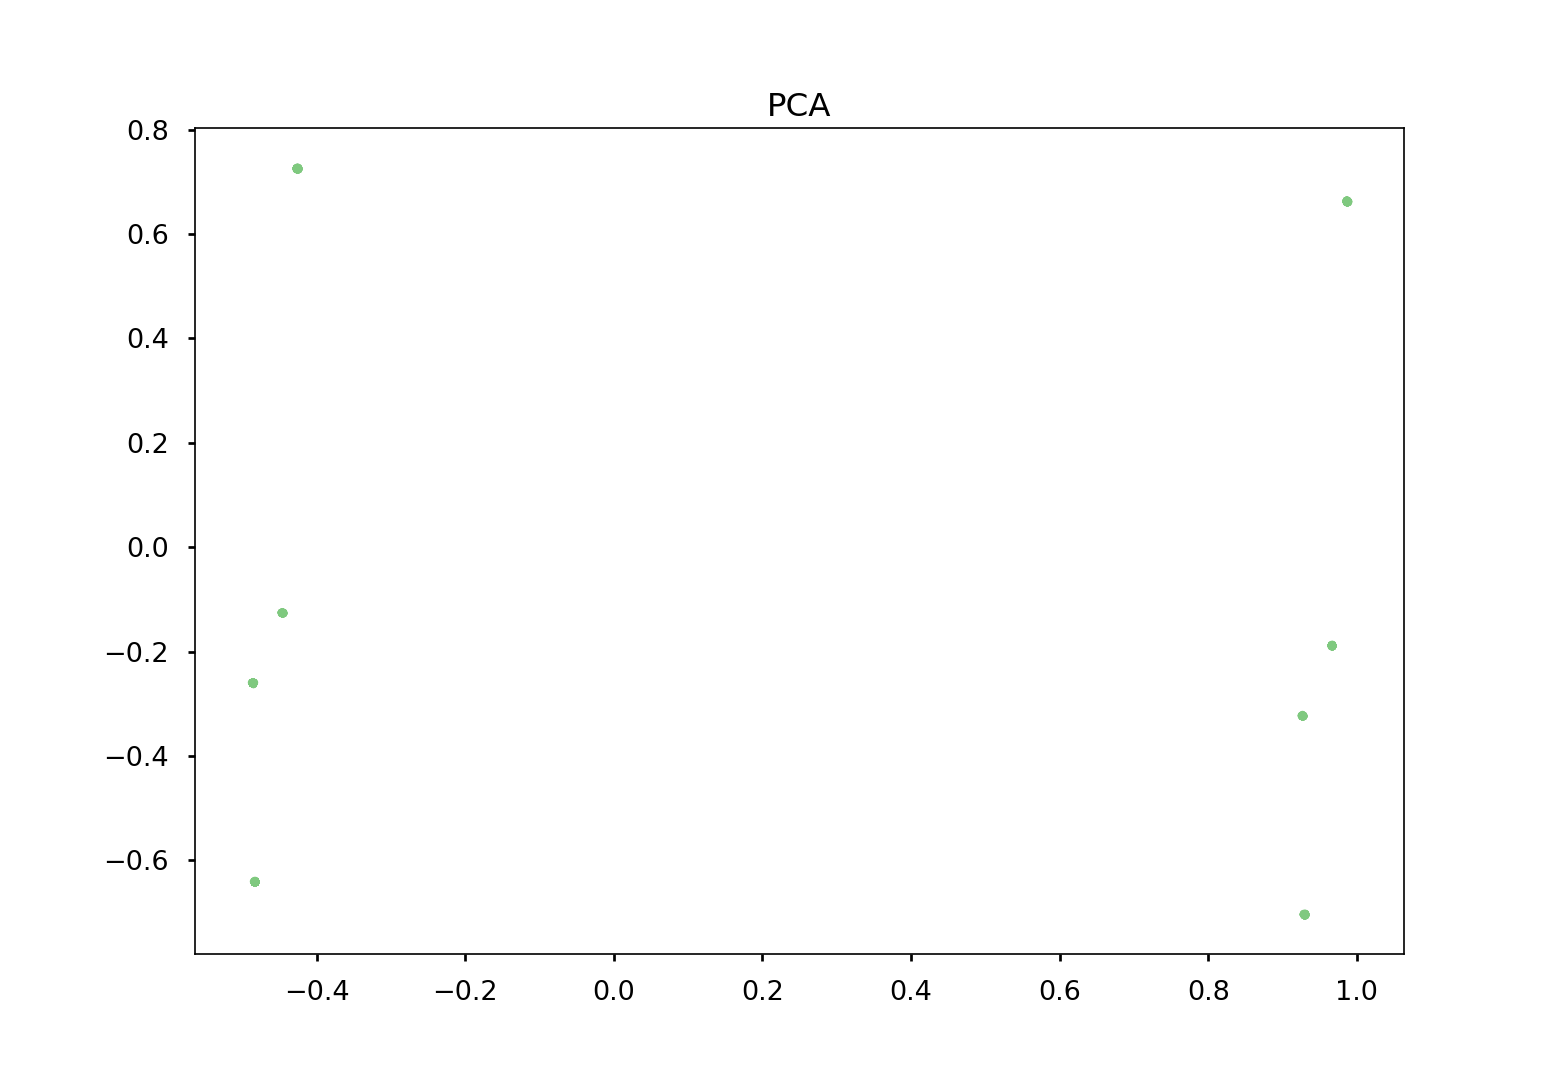

2020-06-10 23:56:35,397 - matplotlib.axes._axes - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [97]:
plot(PCA(n_components=2).fit_transform(df_scaled), 'PCA')

shape: (3680, 2)	samples:
[[  3.566   -1.0388]
 [ 19.3909 -15.7232]
 [ 10.272   35.3351]]


<IPython.core.display.Javascript object>


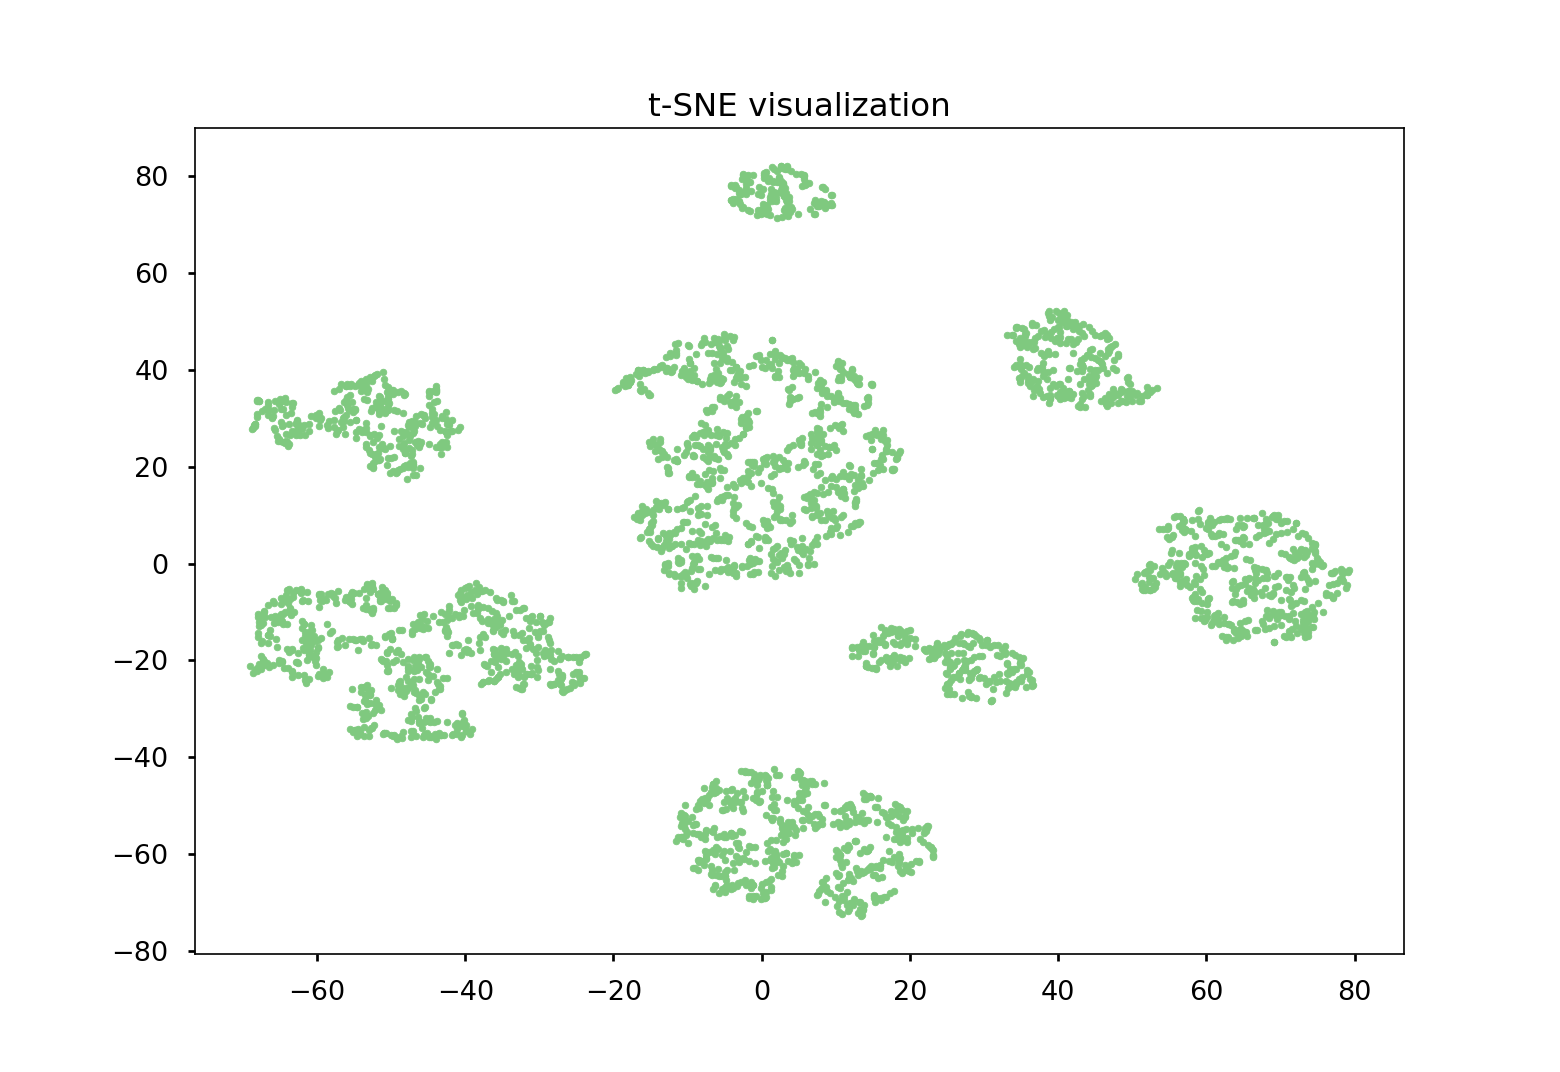

2020-06-10 23:56:56,352 - matplotlib.axes._axes - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [98]:
# n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300
tsne2d = TSNE()
plot(tsne2d.fit_transform(df_scaled), 't-SNE visualization')

In [72]:
max_clusters=20
errors = []
K = range(1,max_clusters)
for k in range(1,max_clusters):
    cl = KMeans(n_clusters=k,random_state=0)
    cl = cl.fit(df_scaled)
    # Sum of squared distances of samples to their closest cluster center.
    errors.append(cl.inertia_)

<IPython.core.display.Javascript object>


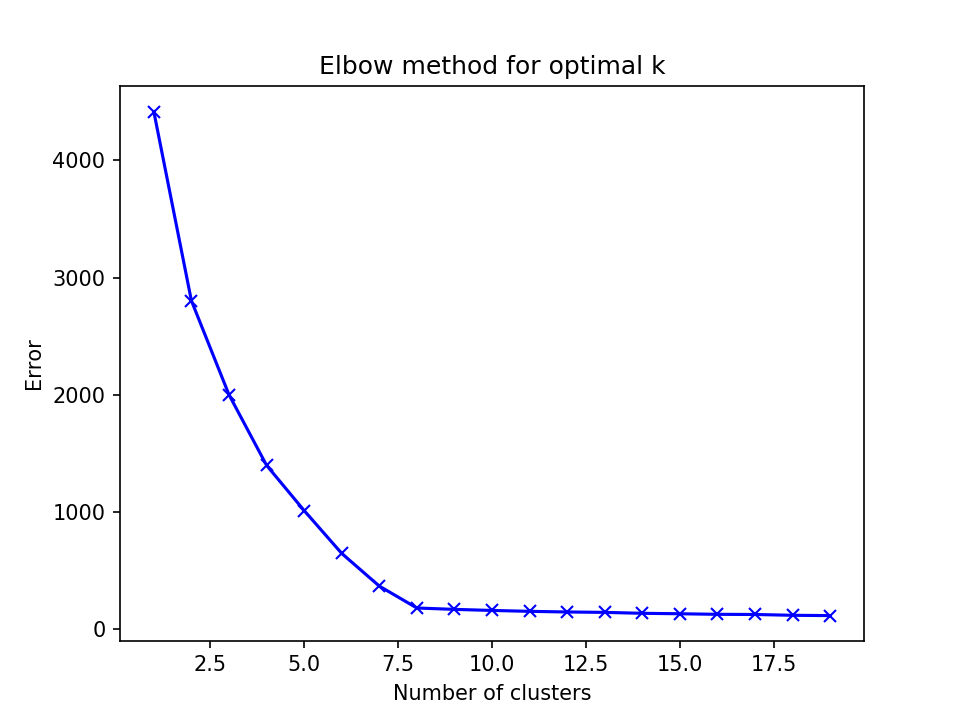

In [74]:
plt.plot(K, errors, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.title('Elbow method for optimal k')
plt.show()

In [83]:
k = 8
cl = KMeans(n_clusters=k, random_state=0 )
labels = cl.fit_predict(df_scaled) + 1
labels.shape

(3680,)

<IPython.core.display.Javascript object>


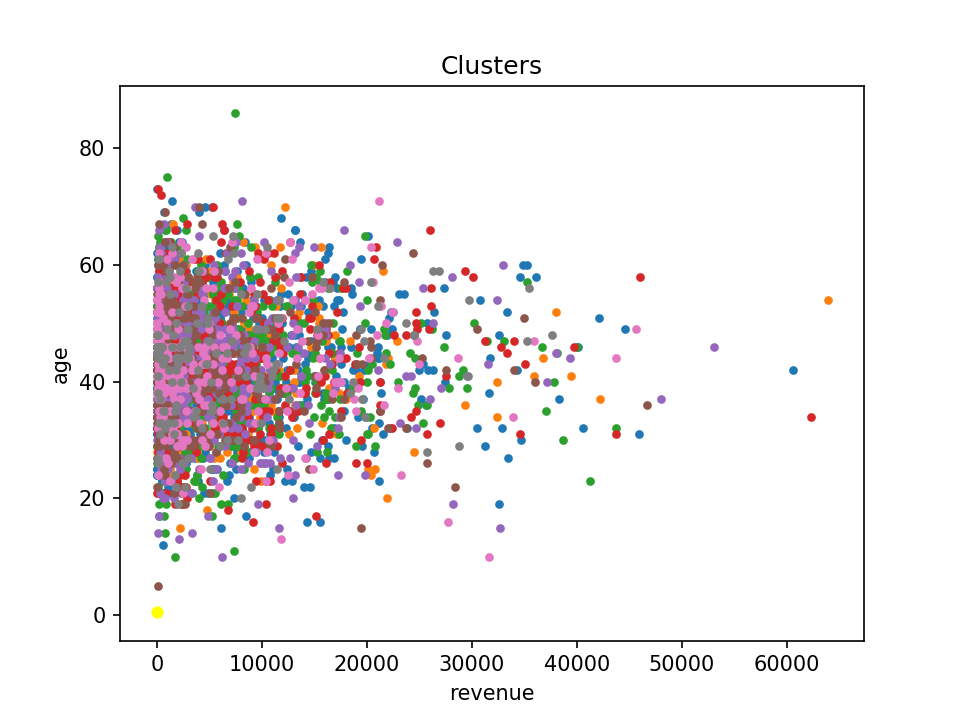

In [85]:
for i in range(k+1):
    plt.scatter(df.iloc[ys==i, 0], df.iloc[ys==i, 1], s=10, label = f'Cluster {i+1}')

plt.scatter(cl.cluster_centers_[:, 0], cl.cluster_centers_[:, 1], s=20, c='yellow', label='Centroids')
plt.title('Clusters')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.show()

shape: (3680, 2)	samples:
[[ -0.2227 -15.773 ]
 [-26.473  -28.9132]
 [ 24.5244 -34.6658]]


<IPython.core.display.Javascript object>


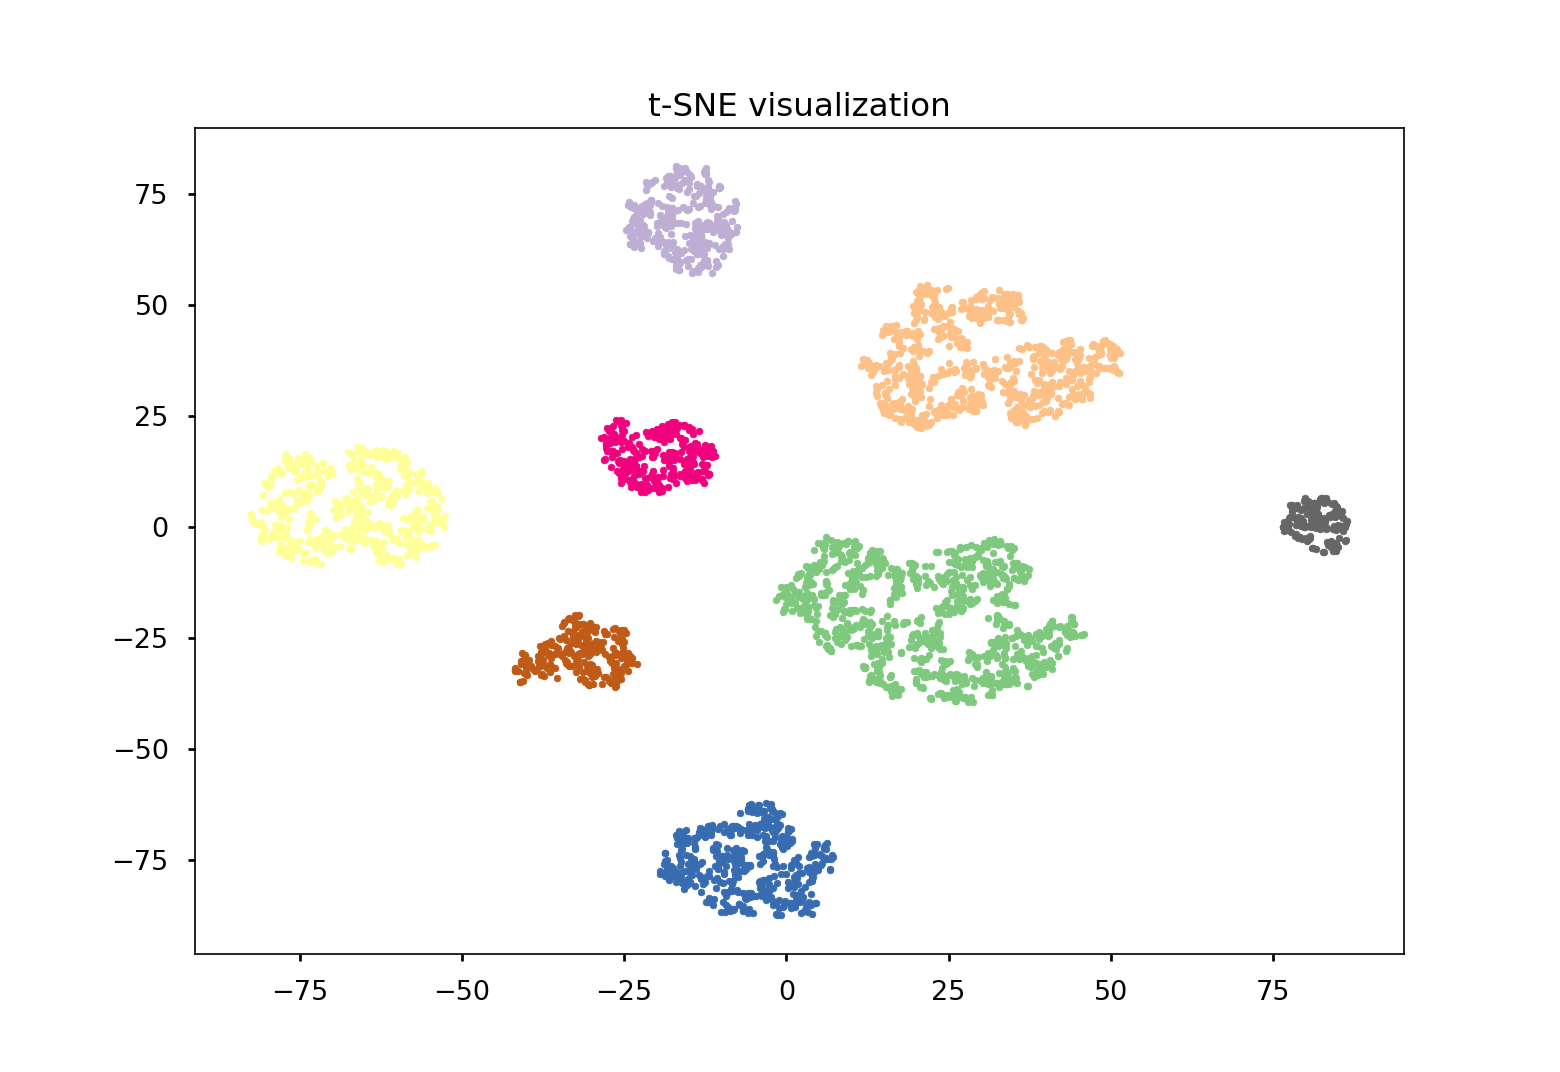

2020-06-10 23:57:29,080 - matplotlib.axes._axes - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-06-10 23:57:29,091 - matplotlib.axes._axes - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-06-10 23:57:29,098 - matplotlib.axes._axes - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB o

In [99]:
# n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300
tsne2d = TSNE(n_components=2, learning_rate=100, perplexity=38, random_state=0, n_iter=2000)
plot(tsne2d.fit_transform(df_scaled), 't-SNE visualization', labels)